In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath('../transcoder_circuits/'))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sae_training.sparse_autoencoder import SparseAutoencoder

In [4]:
import torch
import numpy as np
from einops import *
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

# Load Models

In [5]:
# from nnsight import LanguageModel
# model = LanguageModel('openai-community/gpt2', device_map='auto')

In [9]:
from transformer_lens import HookedTransformer, utils
model = HookedTransformer.from_pretrained('gpt2-small').to(device)

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  mps


In [10]:
transcoder_layer = 8
transcoder_template = "../dufensky_transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
transcoder = SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(transcoder_layer)}.pt").to(device).eval()
sparsity = torch.load(f"{transcoder_template.format(transcoder_layer)}_log_feature_sparsity.pt")
live_features = np.arange(len(sparsity))[(sparsity > -4).numpy()]

In [13]:
W_dec = transcoder.W_dec.detach()
rand_ids = torch.randint(100, size=(5,3,2))
W_dec[rand_ids].shape

torch.Size([5, 3, 2, 768])

# Evaluate

In [50]:
from ood_eval import OODLensEvaluatorConfig, OODLensEvaluator

cfg = OODLensEvaluatorConfig()
def sae_out_fn(x):
    out = transcoder.forward(x)
    return out[0], out[1]
cfg.sae_out_fn = sae_out_fn
ood = OODLensEvaluator(cfg, model, transcoder, sparsity > -3)

In [51]:
ood.evaluate(eval_type = 'add_random_acts')

  0%|          | 0/4883 [00:00<?, ?it/s]

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [56]:
torch.linalg.pinv(transcoder.W_dec.detach().to(torch.float32))

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [20]:
dataloader = ood.get_dataloader()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
batch = next(dataloader)
tokens = batch['input_ids']
batch['labels'] = tokens

Token indices sequence length is longer than the specified maximum sequence length for this model (59807 > 1024). Running this sequence through the model will result in indexing errors


In [32]:
with torch.no_grad():
    hook_in_name = 'blocks.8.ln2.hook_normalized'
    hook_out_name = 'blocks.8.hook_mlp_out'
    loss, cache = model.run_with_cache(batch['input_ids'], return_type="loss",
                                            names_filter=[hook_in_name,
                                                            hook_out_name])

In [35]:
loss

tensor(3.5317, device='mps:0')

In [38]:
def patch_input(activations, hook):
    return torch.randn(*activations.shape).to('mps')

with torch.no_grad():
    loss = model.run_with_hooks(batch['input_ids'], return_type='loss', 
                                fwd_hooks=[(hook_in_name, patch_input)])

In [44]:
with model.hooks(fwd_hooks=[(hook_in_name, patch_input)]):
    loss, cache = model.run_with_cache(batch['input_ids'], return_type='loss',
                                names_filter=[hook_in_name, hook_out_name])

In [46]:
loss

tensor(4.4697, device='mps:0', grad_fn=<NegBackward0>)

In [47]:
cache

ActivationCache with keys ['blocks.8.ln2.hook_normalized', 'blocks.8.hook_mlp_out']

In [37]:
model.reset_hooks()

In [34]:
torch.randn(3,4)

tensor([[-1.4062, -0.3677, -0.4246, -1.6750],
        [-1.6467, -0.6757,  0.8295,  0.9461],
        [-0.8494, -0.3512,  0.1325,  0.1329]])

In [10]:
from nnsight.util import fetch_attr
from nnsight.patching import Patch

In [11]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (generator): WrapperModule()
)

In [21]:
sae_type = 'transcoder'
module_fn = lambda model: model.transformer.h[8].mlp
def sae_out_fn(input):
    with torch.no_grad():
        out = transcoder.forward(input)
    return out[0], out[1]


with torch.no_grad():
    model.eval()
    with model.trace(batch):

        resid_mid = model.transformer.h[8].ln_2.input.save()
        inputs = model.transformer.h[8].ln_2.output.save()
        if sae_type == 'transcoder':
            outputs = module_fn(model).output.save()
        loss = model.output.loss.save()

    y = outputs.value if sae_type=='transcoder' else inputs.value
    y_hat, feat_acts = sae_out_fn(inputs.value)
    mse = (y_hat - y).norm(dim=-1).mean()
   
    with model.trace(batch):
        if sae_type == 'transcoder':
            setattr(module_fn(model), 'output', y_hat)
        else:
            setattr(module_fn(model), 'input', y_hat)
        loss_reconst = model.output.loss.save()

    loss_diff = loss_reconst.value - loss.value
    
    y_mean = y.mean()
    with model.trace(batch):
        if sae_type == 'transcoder':
            setattr(module_fn(model), 'output', y_mean)
        else:
            setattr(module_fn(model), 'input', y_mean)
        loss_mean_ablate = model.output.loss.save()
        

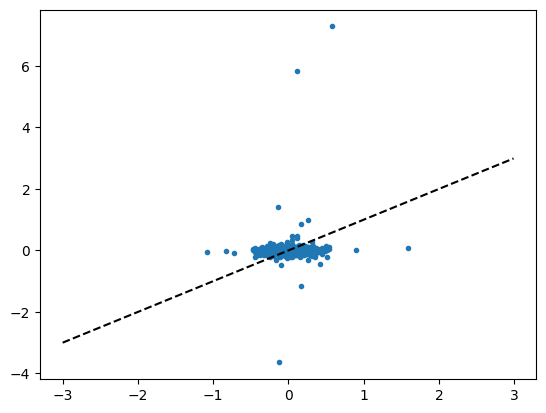

In [12]:
b = 1
pos = 124

plt.plot(inputs.value[b,pos].cpu(), y_hat[b,pos].cpu(),'.')
vec = np.arange(-3,3,0.01)
plt.plot(vec,vec,'k--')

In [13]:
((y - y_hat)**2).mean()

tensor(1.1256, device='mps:0')

In [14]:
(feat_acts > 0).float().sum(dim=-1).mean()

tensor(2.5977, device='mps:0')

In [14]:
loss_reconst.value

tensor(3.6201, device='mps:0')

In [15]:
loss.value

tensor(3.5317, device='mps:0')

In [16]:
loss_mean_ablate.value

tensor(3.6275, device='mps:0')

In [17]:
loss_mean_ablate.value / loss.value

tensor(1.0271, device='mps:0')

In [18]:
loss_reconst.value / loss.value

tensor(1.0250, device='mps:0')

torch.Size([8, 128, 768])

In [13]:
from transformer_lens import HookedTransformer, utils
hooked_model = HookedTransformer.from_pretrained('gpt2-small').to(device)

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  mps


In [27]:
layer=8
mid_hook_point = hooked_model.blocks[layer].hook_resid_mid.name
pre_hook_point = hooked_model.blocks[layer].ln2.hook_normalized.name
post_hook_point = hooked_model.blocks[layer].hook_mlp_out.name
with torch.no_grad():
    hooked_model.eval()
    _, cache = hooked_model.run_with_cache(batch['input_ids'], stop_at_layer=layer+1, 
                                        names_filter=[pre_hook_point, mid_hook_point,
                                                        post_hook_point])
    inputs_lens = cache[pre_hook_point]
    outputs_lens = cache[post_hook_point]
    resid_mid_lens = cache[mid_hook_point]

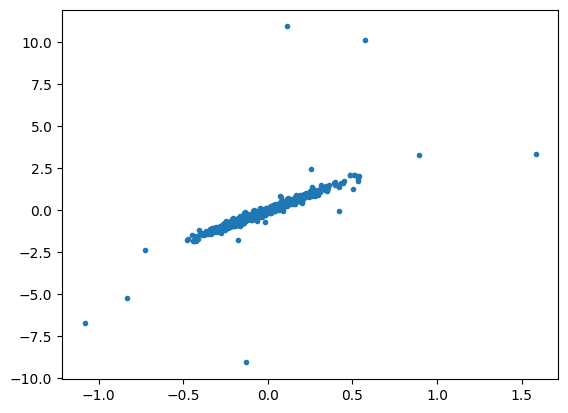

In [17]:
b = 1
pos = 124

plt.plot(inputs.value[b,pos].cpu(), inputs_lens[b,pos].cpu(), '.')

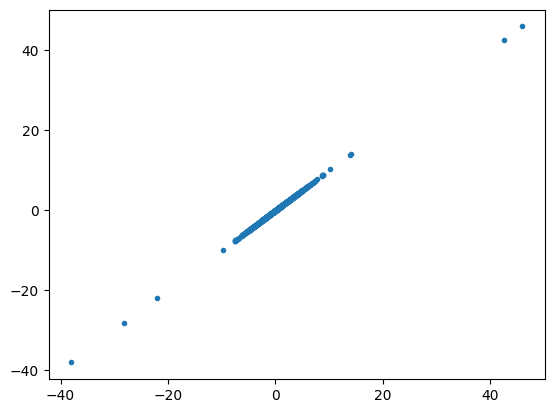

In [29]:
b = 1
pos = 124

plt.plot(resid_mid.value[0][0][b,pos].cpu(), resid_mid_lens[b,pos].cpu(), '.')

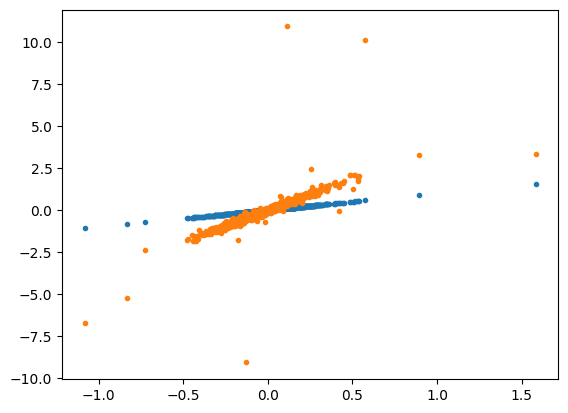

In [46]:
with torch.no_grad():
    x = resid_mid.value[0][0]
    y = model._model.transformer.h[8].ln_2(x)

b = 1
pos = 124

plt.plot(y[b,pos].cpu(), inputs.value[b,pos].cpu(), '.')
plt.plot(y[b,pos].cpu(), inputs_lens[b,pos].cpu(), '.')


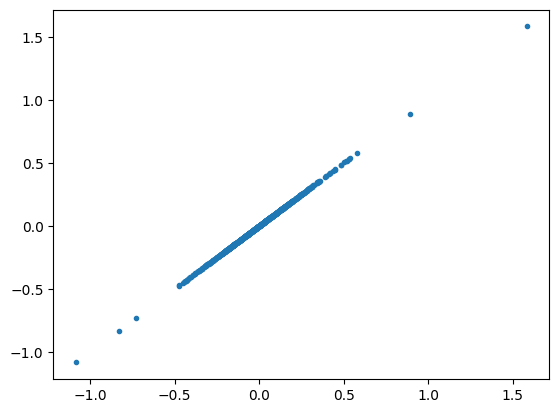

In [55]:
w = model._model.transformer.h[8].ln_2.weight
b = model._model.transformer.h[8].ln_2.bias
eps = model._model.transformer.h[8].ln_2.eps

with torch.no_grad():
    y_hand = x - x.mean(dim=-1, keepdim=True)
    scale = (y_hand.pow(2).mean(-1, keepdim=True) + eps).sqrt()
    y_hand = y_hand/scale
    y_hand = y_hand * w + b

b = 1
pos = 124
plt.plot(y[b,pos].cpu(), y_hand[b,pos].cpu(), '.')

In [61]:
torch.nn.functional.cosine_similarity(inputs.value[b,pos], inputs_lens[b,pos], dim=-1)

tensor(0.8751, device='mps:0')

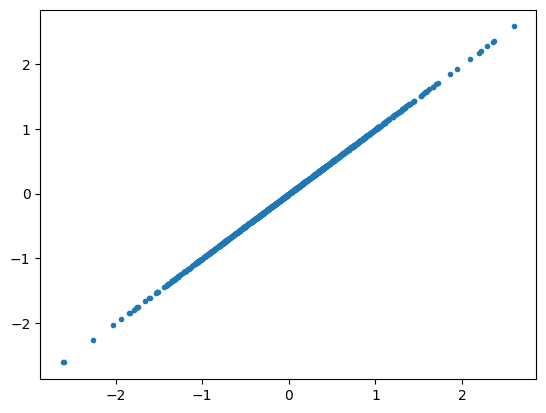

In [18]:
b = 1
pos = 124

plt.plot(outputs[b,pos].cpu(), outputs_lens[b,pos].cpu(), '.')

In [63]:
output.value

CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[ -36.2874,  -35.0114,  -38.0794,  ...,  -40.5164,  -41.3760,
           -34.9193],
         [ -68.8885,  -70.1561,  -71.8408,  ...,  -80.4195,  -78.2553,
           -71.1205],
         [ -82.2950,  -81.6519,  -83.9940,  ...,  -94.4877,  -94.5194,
           -85.6997],
         ...,
         [-113.8674, -111.8628, -113.6634,  ..., -116.7652, -114.8267,
          -112.3621],
         [ -81.8530,  -83.3007,  -91.8192,  ...,  -92.9943,  -89.8382,
           -85.6898],
         [-103.9307, -102.5053, -105.1563,  ..., -109.3099, -110.4195,
          -103.1395]]], device='mps:0', grad_fn=<LinearBackward0>), past_key_values=((tensor([[[[-0.9420,  1.9023,  0.8722,  ..., -1.2703, -0.4792,  1.2469],
          [-1.9590,  2.7141,  2.8423,  ..., -1.1633, -1.6173,  2.1507],
          [-2.6123,  2.0937,  0.9679,  ..., -0.9763, -1.2243,  2.0279],
          ...,
          [-2.4282,  2.4462,  2.1550,  ..., -0.5916, -1.6641,  2.1119],
         

In [37]:
x = batch['input_ids']
[{'input_ids': ids} for ids in x]

[{'input_ids': tensor([50256, 14662,  5312,   198,   198, 13143,  2417,  3438,  5312,   198,
            198, 29014,  7993, 14422,  5312,   198,   198, 27453,  9928,  5312,
            198,   198,   464,  1204,   290, 32904,   286, 13914,   547,  7723,
            287,   383, 25528,   286,   520, 13914,   475,   883, 19336,   423,
            587,  2626,    13,   383, 14555,  4683, 10314,   286, 32904,  3917,
            351,   683,   318,   287,   262, 19336,   286, 20653,   286, 42998,
            357, 49561,  1906, 46438,   828,   508, 15802,   262,  1708,    25,
            317, 11503,  3706,  1305,    13, 43990, 23515,   373, 25448,   257,
           4928,   286,   520, 13914,    11,   543,   550,   587,  7384,   290,
          22999,    11,   290,  9657,   867,   670,  3653,   284,  9989,   262,
           1693,    13,  1629,   530,   966,  1141,   262,  5103,    11,   339,
           1043,  2241,   351,  2147,   284,  3745,   606,    13,   679, 32168,
            284,   520,    

In [17]:
dir(model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_inputs',
 '_example_input',
 '_forward',
 '_generation',
 '_load_local',
 '_load_meta',
 '_prepare_inputs',
 '_register_increment_hook',
 '_scan',
 '_tokenize',
 'args',
 'automodel',
 'config',
 'custom_model',
 'dispatch',
 'dispatch_local_model',
 'dispatched',
 'edits',
 'forward',
 'generate',
 'invoke',
 'kwargs',
 'local_model',
 'meta_model',
 'modulize',
 'repoid_path_clsname',
 'tokenizer']

In [13]:
from nnsight import LanguageModel

model = LanguageModel('openai-community/gpt2', device_map='auto')

with model.trace('The Eiffel Tower is in the city of'):

      hidden_states = model.transformer.h[-1].output[0].save()

      output = model.output.save()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [53]:
import nnsight

In [60]:
nnsight.__spec__

ModuleSpec(name='nnsight', loader=<_frozen_importlib_external.SourceFileLoader object at 0x103f98b30>, origin='/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nnsight/__init__.py', submodule_search_locations=['/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/nnsight'])

In [55]:
dir(nnsight)

['AbstractContextManager',
 'Any',
 'CONFIG',
 'ConfigModel',
 'DEFAULT_PATCHER',
 'DiffuserModel',
 'LanguageModel',
 'List',
 'Module',
 'NNsightModel',
 'PATH',
 'Patch',
 'Patcher',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_meta_lib_dont_use_me_use_register_meta',
 'activate_recent_meta',
 'annotations',
 'aten',
 'contexts',
 'editing',
 'einops',
 'file',
 'getmembers',
 'global_decomposition_table',
 'importlib',
 'intervention',
 'isfunction',
 'key',
 'local_scalar_dense_meta',
 'logger',
 'meta_nonzero',
 'meta_nonzero_wrapper',
 'meta_where_wrapper',
 'models',
 'module',
 'noop_wrapper',
 'onehot_wrapper',
 'os',
 'patching',
 'proxy_wrapper',
 'pydantics',
 'register_meta',
 'repeat_interleave_wrapper',
 'torch',
 'tracing',
 'types',
 'util',
 'value',
 'wraps',
 'yaml']

In [24]:
transcoder.hook_dict['hook_sae_in'].name

'hook_sae_in'

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [19]:
dir(transcoder)

['T_destination',
 'W_dec',
 'W_enc',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_p

In [91]:
transcoder.cfg

LanguageModelSAERunnerConfig(model_name='gpt2-small', hook_point='blocks.8.ln2.hook_normalized', hook_point_layer=8, hook_point_head_index=None, dataset_path='Skylion007/openwebtext', is_dataset_tokenized=False, context_size=128, use_cached_activations=False, cached_activations_path='activations/Skylion007_openwebtext/gpt2-small/blocks.8.ln2.hook_normalized', d_in=768, n_batches_in_buffer=128, total_training_tokens=300000000, store_batch_size=32, device='mps', seed=42, dtype=torch.float32, is_transcoder=True, out_hook_point='blocks.8.hook_mlp_out', out_hook_point_layer=8, d_out=768, is_sparse_connection=False, sparse_connection_sae_path=None, sparse_connection_l1_coeff=None, sparse_connection_use_W_enc=True, b_dec_init_method='mean', expansion_factor=32, from_pretrained_path=None, l1_coefficient=8e-05, lr=0.0004, lr_scheduler_name='constantwithwarmup', lr_warm_up_steps=5000, train_batch_size=4096, use_ghost_grads=True, feature_sampling_window=1000, feature_sampling_method='Anthropic', 

In [99]:
freqs = 10**(sparsity)
freqs.sum()

tensor(67.8501)

In [21]:
W_dec = transcoder.W_dec.detach()
mask = sparsity > -2.5
cos_sims = (W_dec[mask] @ W_dec[mask].T).cpu()

In [22]:
orig_mask = cos_sims < 0.2
cos_sims[orig_mask] = 0

In [13]:
eigvals, eigvecs = np.linalg.eigh(cos_sims)

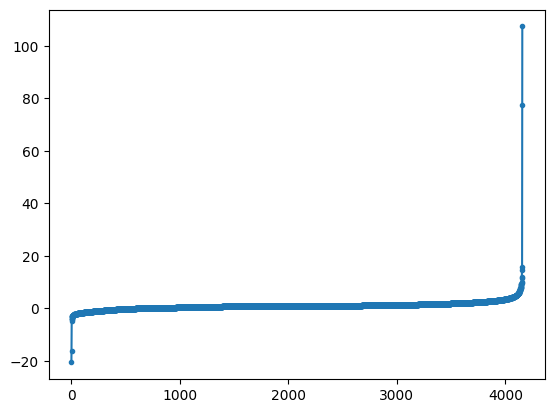

In [14]:
plt.plot(eigvals,'.-')

In [16]:
mask = eigvals > 0
cos_sims_hat = eigvecs[:,mask] @ np.diag(eigvals[mask]) @ eigvecs[:,mask].T

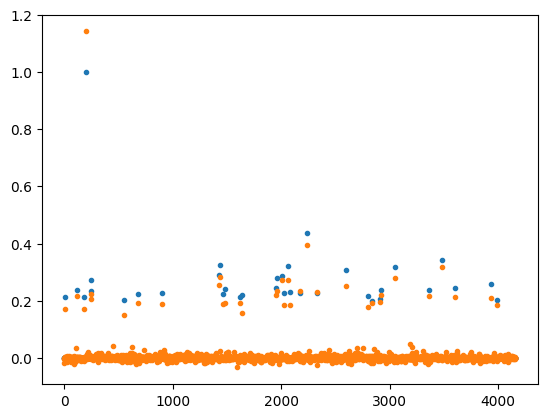

In [20]:
i = 200
plt.plot(cos_sims[i],'.')
plt.plot(cos_sims_hat[i], '.')

In [30]:
mask = eigvals > 0
cos_sims_hat = eigvecs[:,mask] @ np.diag(eigvals[mask]) @ eigvecs[:,mask].T

cos_sims2 = cos_sims.clone()
cos_sims2[orig_mask] = torch.tensor(cos_sims_hat)[orig_mask]

In [31]:
eigvals, eigvecs = np.linalg.eigh(cos_sims2)

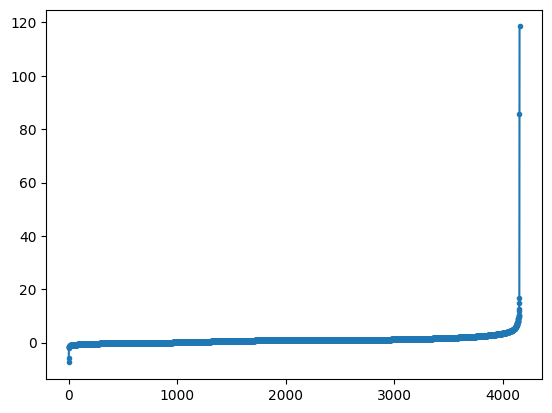

In [32]:
plt.plot(eigvals,'.-')

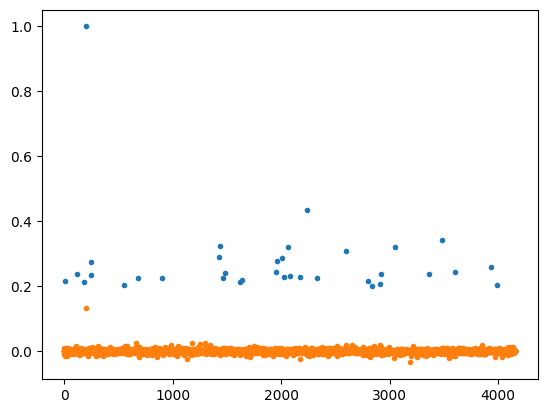

In [64]:
mask = (eigvals < 1) & (eigvals > 0)
cos_sims_hat = eigvecs[:,mask] @ np.diag(eigvals[mask]) @ eigvecs[:,mask].T

i = 200

plt.plot(cos_sims[i],'.')
plt.plot(cos_sims_hat[i], '.')

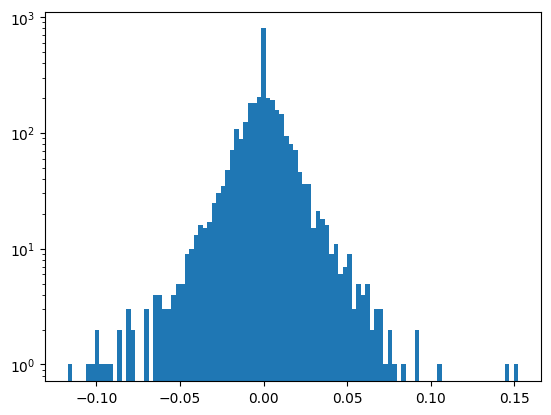

In [66]:
# idx = -1000
mask = eigvals > 0
plt.hist(np.sqrt(eigvals[mask]) * eigvecs[i,mask], 100)
plt.yscale('log')